# Thư viện

In [2]:
import pandas as pd
import numpy as np
import re
from underthesea import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertForSequenceClassification

import torch
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [3]:
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import string

# DATA CLEANING

In [4]:
Reviews = pd.read_excel("Reviews.xlsx")

In [5]:
Reviews.head(2)

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,4,4,Yes
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,4,5,Yes


In [6]:
Overview_Companies = pd.read_excel("Overview_Companies.xlsx")
Overview_Companies.head(2)

,id,Company Name,Company Type,Company industry,Company size,Country,Working days,Overtime Policy,Company overview,Our key skills,Why you'll love working here,Location,Href
0,0,1BITLAB Technology,IT Outsourcing,Software Development Outsourcing,1-50 employees,Vietnam,Monday - Friday,No OT,1BITLAB Technology\nCông ty cổ phần công nghệ ...,NaN,NaN,"{'Ha Noi': ['81 Lê Đức Thọ, Nam Từ LIêm, Hà Nộ...",https://itviec.com/companies/1bitlab-technology\n
1,1,1test,IT Product,IT Services and IT Consulting,1-50 employees,South Korea,Monday - Friday,No OT,1test\nIs an innovative educational technology...,NaN,NaN,"{'Ho Chi Minh': ['Remote, District 1, Ho Chi M...",https://itviec.com/companies/1test\n


In [8]:
Overview_Reviews = pd.read_excel("Overview_Companies.xlsx")
Overview_Reviews.head(2)

,id,Company Name,Company Type,Company industry,Company size,Country,Working days,Overtime Policy,Company overview,Our key skills,Why you'll love working here,Location,Href
0,0,1BITLAB Technology,IT Outsourcing,Software Development Outsourcing,1-50 employees,Vietnam,Monday - Friday,No OT,1BITLAB Technology\nCông ty cổ phần công nghệ ...,NaN,NaN,"{'Ha Noi': ['81 Lê Đức Thọ, Nam Từ LIêm, Hà Nộ...",https://itviec.com/companies/1bitlab-technology\n
1,1,1test,IT Product,IT Services and IT Consulting,1-50 employees,South Korea,Monday - Friday,No OT,1test\nIs an innovative educational technology...,NaN,NaN,"{'Ho Chi Minh': ['Remote, District 1, Ho Chi M...",https://itviec.com/companies/1test\n


In [7]:
# Chọn các cột cần lấy từ Overview_Companies
columns_to_add = [
    'id',
    'Company Type',
    'Company industry',
    'Company size',
    'Country',
    'Working days',
    'Overtime Policy'
]

# Gộp bảng bằng inner join theo cột 'id'
Reviews = Reviews.merge(
    Overview_Companies[columns_to_add],
    on='id',
    how='left'  # dùng 'left' để giữ nguyên tất cả dữ liệu trong Reviews
)

# Kiểm tra kết quả
Reviews.head()


,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,Culture & fun,Office & workspace,Recommend?,Company Type,Company industry,Company size,Country,Working days,Overtime Policy
0,4,Accenture,March 2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,4,4,Yes,IT Service and IT Consulting,IT Services and IT Consulting,301-500 employees,Vietnam,Monday - Friday,No OT
1,4,Accenture,January 2025,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,4,5,Yes,IT Service and IT Consulting,IT Services and IT Consulting,301-500 employees,Vietnam,Monday - Friday,No OT
2,4,Accenture,October 2023,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,3,3,Yes,IT Service and IT Consulting,IT Services and IT Consulting,301-500 employees,Vietnam,Monday - Friday,No OT
3,4,Accenture,February 2025,good environment for fresher,good env. for fresher to learn and improve the...,Need to forcus more on benefit and evaluate co...,3,2,2,3,4,4,No,IT Service and IT Consulting,IT Services and IT Consulting,301-500 employees,Vietnam,Monday - Friday,No OT
4,4,Accenture,February 2023,"Môi trường làm việc thoải mái, vui vẻ","- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và ...",- Phát triển văn phòng để rộng rãi hơn\n- Công...,4,3,4,4,4,3,Yes,IT Service and IT Consulting,IT Services and IT Consulting,301-500 employees,Vietnam,Monday - Friday,No OT


In [66]:
# Độ dài review
Reviews['combined_text'] = (
    Reviews['Title'].fillna('') + ' ' +
    Reviews['What I liked'].fillna('') + ' ' +
    Reviews['Suggestions for improvement'].fillna('')
)
Reviews['review_len'] = Reviews['combined_text'].astype(str).apply(lambda x: len(x.split()))

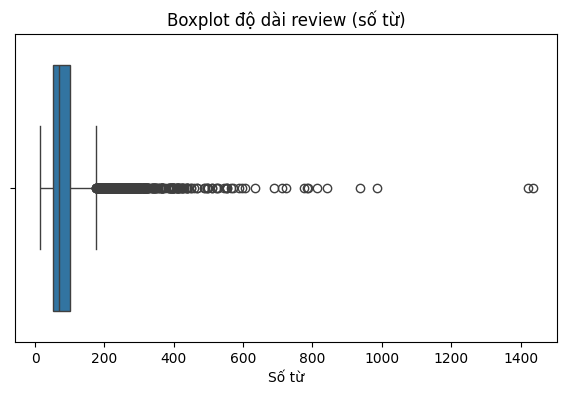

In [68]:
# Trực quan hóa boxplot để kiểm tra outliers
plt.figure(figsize=(7, 4))
sns.boxplot(x=Reviews['review_len'])
plt.title('Boxplot độ dài review (số từ)')
plt.xlabel('Số từ')
plt.show()


## Data Cleaning

## Tiền xử lý dữ liệu tiếng Việt

In [69]:
# Đọc stopwords
with open('vietnamese-stopwords.txt', encoding='utf-8') as f:
    stopwords = set([line.strip() for line in f.readlines() if line.strip()])

In [70]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-záàảãạăắằẳẵặâấầẩẫậđéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵ\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [71]:
def preprocess_vietnamese(text):
    text = clean_text(text)
    tokens = word_tokenize(text, format="text").split()
    tokens = [t for t in tokens if t not in stopwords]
    return ' '.join(tokens)

In [72]:
Reviews['text_processed'] = Reviews['combined_text'].apply(preprocess_vietnamese)

#### Normalize

In [13]:
import re
# Hàm để chuẩn hóa các từ có ký tự lặp
def normalize_repeated_characters(text):
    # Thay thế mọi ký tự lặp liên tiếp bằng một ký tự đó
    # Ví dụ: "lònggggg" thành "lòng", "thiệtttt" thành "thiệt"
    return re.sub(r'(.)\1+', r'\1', text)

# Áp dụng hàm chuẩn hóa cho văn bản
# print(normalize_repeated_characters(example))

In [73]:
Reviews['text_processed'] = Reviews['combined_text'].apply(lambda x: normalize_repeated_characters(x))


In [74]:
# Apply the process_text function
Reviews['text_processed'] = Reviews['combined_text'].apply(lambda x: process_text(x, emoji_dict, teen_dict, wrong_lst,english_dict))

In [75]:
Reviews.tail(5)

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,...,Overtime Policy,review_text,processed_text,pos_count,neg_count,label_sentiment,Review_Year,combined_text,review_len,text_processed
8412,477,Zuhlke Engineering Vietnam,2021-11-01,Môi trường cực kì tốt,Văn hoá: Mình rất ấn tượng khi lúc phỏng vấn n...,Hiện tại công ty còn chân ướt chân ráo vô Việt...,4,4,4,5,...,No OT,Văn hoá: Mình rất ấn tượng khi lúc phỏng vấn n...,văn_hóa ấn_tượng phỏng_vấn fedback nhiệt_tình ...,0,0,1,2021,Môi trường cực kì tốt Văn hoá: Mình rất ấn tượ...,149,môi trường cực kì tốt văn hoá mình rất ấn tượn...
8413,477,Zuhlke Engineering Vietnam,2021-11-01,Môi trường làm việc cực kỳ cởi mở,"- Sếp thoải mái, ý kiến của mọi nhân viên đều ...","Công ty mới mở, nên nhiều thứ chưa được định h...",4,4,5,5,...,No OT,"- Sếp thoải mái, ý kiến của mọi nhân viên đều ...",sếp thoải_mái ý_kiến nhân_viên quân_trọng đồng...,0,0,1,2021,Môi trường làm việc cực kỳ cởi mở - Sếp thoải ...,211,môi trường làm việc cực kỳ cởi mở sếp thoải má...
8414,477,Zuhlke Engineering Vietnam,2021-11-01,"Công ty tốt, nhân viên được cấp Macbook Pro",Best interview experience: the interviewers ar...,As I started in Zuhlke Vietnam during lockdown...,5,5,5,5,...,No OT,Best interview experience: the interviewers ar...,interview interviewers chúng_tôi thân_thiện di...,0,0,2,2021,"Công ty tốt, nhân viên được cấp Macbook Pro Be...",243,công tốt nhân viên được cấp chuyên nghiệp tốt ...
8415,477,Zuhlke Engineering Vietnam,2021-11-01,Great place to leverage your skills,"- Environment: open, flat organization, divers...","Zuhlke Vietnam is still young, and we might ne...",5,4,5,4,...,No OT,"- Environment: open, flat organization, divers...",environment open flat organization diverse rec...,0,0,1,2021,Great place to leverage your skills - Environm...,199,tuyệt quá địa điểm đến leverage của bạn skills...
8416,477,Zuhlke Engineering Vietnam,2021-11-01,Môi trường rất tốt để GROW,+ MacBook Max Options cho nhân viên.\n+ Magic ...,"+ Công ty mới nên ít người biết đến, công ty c...",5,4,4,5,...,No OT,+ MacBook Max Options cho nhân viên.\n+ Magic ...,macbok tối_đa tùy magic chuột magic keyboard n...,0,0,1,2021,Môi trường rất tốt để GROW + MacBook Max Optio...,112,môi trường rất tốt để grow tối đa tùy chọn cho...


#### Chuẩn hóa tiếng Việt

In [76]:
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [77]:
Reviews["text_processed"] = Reviews["text_processed"].apply(lambda x: covert_unicode(x))

#### process_special_word - KHÔNG

In [78]:
def process_special_word(text):
    # có thể có nhiều từ đặc biệt cần ráp lại với nhau
    new_text = ''
    text_lst = text.split()
    i= 0
    # không, chẳng, chả...
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [79]:
Reviews["text_processed"] = Reviews["text_processed"].apply(lambda x: process_special_word(x))

#### process_postag_thesea

In [80]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['N','Np','A','AB','V','VB','VY','R']
        # lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

In [81]:
Reviews["text_processed"] = Reviews["text_processed"].apply(lambda x: process_postag_thesea(x))

In [82]:
# Remove Stopword
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

Reviews["text_processed"] = Reviews["text_processed"].apply(lambda x: remove_stopword(x,stopwords_lst))

In [83]:
Reviews.head(5)

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,...,Overtime Policy,review_text,processed_text,pos_count,neg_count,label_sentiment,Review_Year,combined_text,review_len,text_processed
0,4,Accenture,2025-03-01,"Môi trường thoải mái, ít áp lực, có thể làm vi...","Môi trường thoải mái, ít áp lực, có thể làm vi...",Cần đánh giá KPI khách quan và phân chia công ...,4,4,4,4,...,No OT,"Môi trường thoải mái, ít áp lực, có thể làm vi...",môi_trường thoải_mái áp_lực có_thể làm_việc hy...,0,0,1,2025,"Môi trường thoải mái, ít áp lực, có thể làm vi...",105,môi_trường thoải_mái áp_lực có_thể làm_việc hy...
1,4,Accenture,2025-01-01,Công ty trẻ trung năng động,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",Nên nghiên cứu lại range lương của thì trường....,4,3,4,4,...,No OT,"Cơ sở vật chất đẹp, công ty trẻ trung năng độn...",cơ_sở_vật_chất đẹp_công trẻ chế_độ làm_việc hy...,0,0,1,2025,Công ty trẻ trung năng động Cơ sở vật chất đẹp...,72,công trẻ năng_động_cơ_sở_vật_chất đẹp_công trẻ...
2,4,Accenture,2023-10-01,Môi trường làm việc thoải mái vui vẻ,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",Do công ty làm outsourcing về mảng system nên ...,3,3,3,3,...,No OT,"Mội người thân thiện, giúp đỡ lẫn nhau. Chương...",mội thân_thiện giúp_đỡ lẫn chương_trình intern...,0,0,1,2023,Môi trường làm việc thoải mái vui vẻ Mội người...,81,môi_trường làm_việc thoải_mái vẻ mội thân_thiệ...
3,4,Accenture,2025-02-01,good environment for fresher,good env. for fresher to learn and improve the...,Need to forcus more on benefit and evaluate co...,3,2,2,3,...,No OT,good env. for fresher to learn and improve the...,fresher learn ability yên_tĩnh opened flexible...,0,0,0,2025,good environment for fresher good env. for fre...,41,environment fresher fresher learn ability yên_...
4,4,Accenture,2023-02-01,"Môi trường làm việc thoải mái, vui vẻ","- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và ...",- Phát triển văn phòng để rộng rãi hơn\n- Công...,4,3,4,4,...,No OT,"- Văn phòng đẹp, cơ sở vật chất tốt\n- Sếp và ...",văn_phòng đẹp cơ_sở vật_chất tốt_sếp đồng_nghi...,0,0,1,2023,"Môi trường làm việc thoải mái, vui vẻ - Văn ph...",74,môi_trường làm_việc thoải_mái vẻ văn_phòng đẹp...


## LABELING

In [84]:
positive_words = [
    "ấn tượng", "xuất chúng", "tuyệt hảo", "đáng giá", "mượt mà",
    "vượt mong đợi", "chu đáo", "yên tâm", "tốt đẹp", "nhanh nhẹn",
    "dễ thương", "hiếm gặp", "hấp dẫn", "vững chắc", "chuẩn chỉnh", "tin tưởng",
    "nhẹ nhàng", "khéo léo", "trách nhiệm", "linh hoạt",
    "độc đáo", "hợp lý", "thấu hiểu", "thành thạo", "tự tin", "vui nhộn", "sạch sẽ", "chuẩn mực",
    "cởi mở", "tận tình", "gương mẫu", "tốt nghiệp", "kỹ năng", "thành công", "nổi bật", "hoà đồng", "hiện đại",
    "tiện lợi", "sáng sủa", "đa năng", "xứng đáng", "phục vụ", "đáp ứng", "phấn khởi", "năng suất", "điểm cộng",
    "lý tưởng", "nhẹ nhàng", "quý giá", "hoàn mỹ"
]

In [85]:
negative_words = [
    "tầm thường", "thiếu sót", "bực mình", "vô lý", "lạnh lùng",
    "lộn xộn", "nản", "rệu rã", "thất vọng", "khó thở",
    "kỳ quặc", "bấp bênh", "đáng lo", "thiếu kiểm soát", "xáo trộn",
    "thiếu chuyên môn", "mơ hồ", "lộn xộn", "vô tổ chức", "khó nắm bắt",
    "bất tiện", "nguy hiểm", "ngớ ngẩn", "bực bội", "thiếu hiệu quả",
    "căng thẳng", "rời rạc", "lâu lắc", "dở", "lười biếng",
    "thiếu trách nhiệm", "gian dối", "rập khuôn", "trễ nải", "kém cỏi",
    "khó tiếp cận", "lơ là", "bỏ mặc", "thụ động", "xa cách",
    "kém hấp dẫn", "thiếu động lực", "độc đoán", "mập mờ", "thiếu minh bạch",
    "thiếu chuyên sâu", "vô cảm", "xúc phạm", "xui xẻo", "rút lui",
    "thất bại", "cãi vã", "trì trệ", "thiếu logic", "làm màu",
    "ngột ngạt", "khó hiểu", "gây ức chế", "quá tải", "thiếu tôn trọng",
    "thiếu hỗ trợ", "vô trách nhiệm", "bất mãn", "mất lòng tin", "thiếu linh hoạt",
    "kỳ thị", "khó xử lý", "bất công", "xa vời", "mập mờ", 
    "giả tạo", "thiếu tính người", "đè nén", "vô lý", "chậm chạp"
]

In [86]:
from collections import Counter

# Các cột đánh giá
rating_columns = [
    'Salary & benefits', 'Training & learning', 'Management cares about me',
    'Culture & fun', 'Office & workspace'
]

# Hàm đếm số từ tích cực / tiêu cực
def count_pos_neg_words(text, pos_words, neg_words):
    text = text.replace("_", " ").lower()
    tokens = text.split()
    counter = Counter(tokens)
    pos_count = sum(counter[w] for w in pos_words if w in counter)
    neg_count = sum(counter[w] for w in neg_words if w in counter)
    return pos_count, neg_count

# Tính pos_count và neg_count cho từng dòng
Reviews[['pos_count', 'neg_count']] = Reviews['text_processed'].apply(
    lambda x: pd.Series(count_pos_neg_words(x, positive_words, negative_words))
)

#  Hàm gán nhãn cảm xúc
def classify_sentiment(row):
    ratings = row[rating_columns].values
    pos_count = row['pos_count']
    neg_count = row['neg_count']

    # Logic phân loại
    if all(r == 5 for r in ratings):
        return 2  # Tích cực
    elif all(r >= 4 for r in ratings) and (pos_count > neg_count):
        return 2  # Tích cực
    elif any(r <= 2 for r in ratings) and (ratings.mean() <= 3 or pos_count <= neg_count):
        return 0  # Tiêu cực
    else:
        return 1  # Trung tính

#  Gán nhãn cảm xúc
Reviews['label_sentiment'] = Reviews.apply(classify_sentiment, axis=1)


In [87]:
# Thống kê số lượng từng loại sentiment
def count_sentiment_distribution(df):
    sentiment_map = {0: "Tiêu cực", 1: "Trung tính", 2: "Tích cực"}
    counts = df['label_sentiment'].value_counts().sort_index()
    for label, name in sentiment_map.items():
        print(f"{name}: {counts.get(label, 0)} phản hồi")
count_sentiment_distribution(Reviews)


Tiêu cực: 1947 phản hồi
Trung tính: 5352 phản hồi
Tích cực: 1118 phản hồi


# EDA

In [88]:
# Các cột cần phân tích
eda_columns = [
    "Rating",
    "Salary & benefits",
    "Training & learning",
    "Management cares about me",
    "Culture & fun",
    "Office & workspace"
]


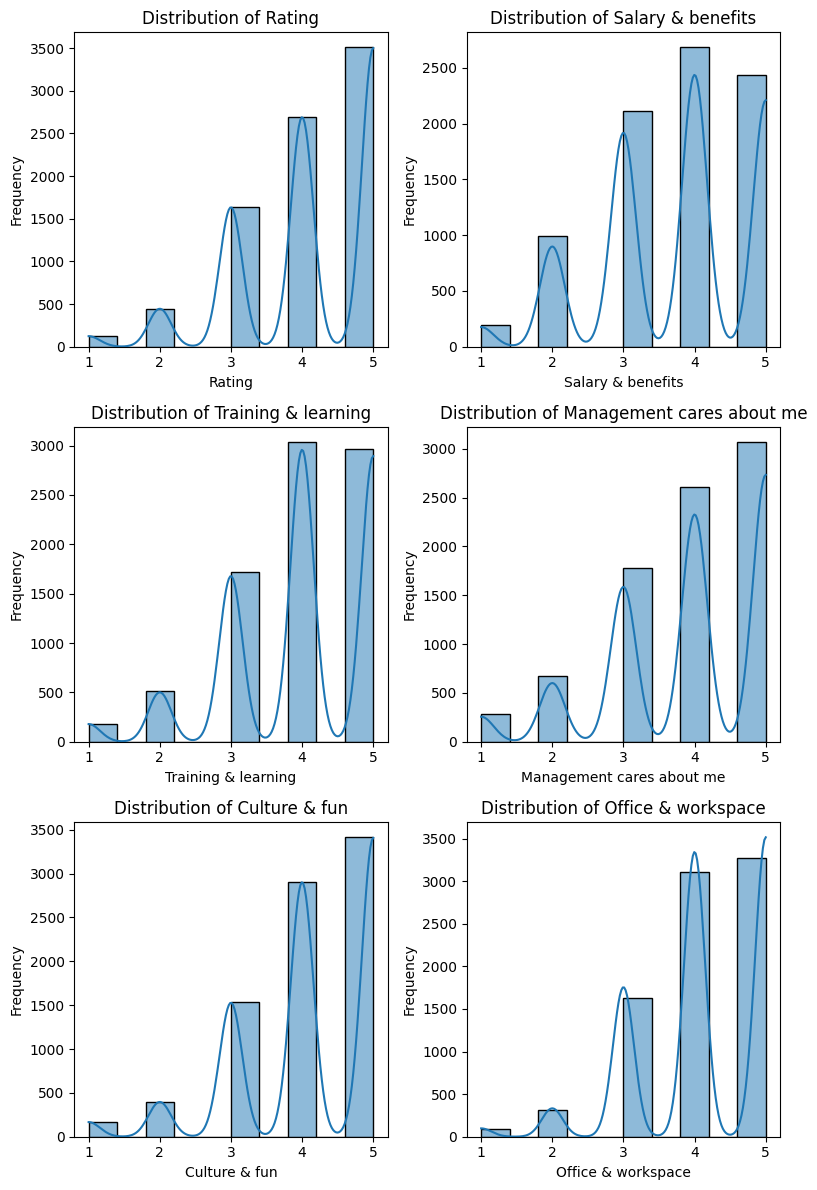

In [89]:
# Vẽ biểu đồ phân phối
plt.figure(figsize=(8, 12))
for i, column in enumerate(eda_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(Reviews[column], bins=10, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [90]:
A= (Reviews[Reviews['label_sentiment'] == 0])
A.head(20)

,id,Company Name,Cmt_day,Title,What I liked,Suggestions for improvement,Rating,Salary & benefits,Training & learning,Management cares about me,...,Overtime Policy,review_text,processed_text,pos_count,neg_count,label_sentiment,Review_Year,combined_text,review_len,text_processed
3,4,Accenture,2025-02-01,good environment for fresher,good env. for fresher to learn and improve the...,Need to forcus more on benefit and evaluate co...,3,2,2,3,...,No OT,good env. for fresher to learn and improve the...,fresher learn ability yên_tĩnh opened flexible...,0,0,0,2025,good environment for fresher good env. for fre...,41,environment fresher fresher learn ability yên_...
7,4,Accenture,2022-10-01,Môi trường đa quốc gia xịn xò,- Laptop và các thiết bị khá xịn xò\n- Môi trư...,Số lượng nhân viên tăng dẫn tới văn phòng hơi ...,4,4,4,4,...,No OT,- Laptop và các thiết bị khá xịn xò\n- Môi trư...,máy_tính_xách thiết_bị xịn_xò môi_trường cơ_hộ...,0,0,0,2022,Môi trường đa quốc gia xịn xò - Laptop và các ...,73,môi_trường đa_quốc xịn xò máy_tính_xách thiết_...
10,4,Accenture,2022-05-01,Môi trường xịn,"- Văn phòng đẹp, hơi chật.\n- Vừa hợp nhất với...",- Cần cải thiện các phúc lợi và chính sách cho...,4,2,4,4,...,No OT,"- Văn phòng đẹp, hơi chật.\n- Vừa hợp nhất với...",văn_phòng đẹp hơi chật hợp acenture công multi...,0,0,0,2022,"Môi trường xịn - Văn phòng đẹp, hơi chật.\n- V...",76,môi_trường xịn văn_phòng đẹp hơi chật hợp acce...
11,4,Accenture,2021-02-01,Môi tường tốt,"Môi trường ổn\nGiờ giấc linh hoạt, có thể wfh ...","Không thể cải thiện cái j cả, vì cty mẹ ở pháp...",2,2,1,1,...,No OT,"Môi trường ổn\nGiờ giấc linh hoạt, có thể wfh ...",môi_trường ổn giờ_giấc_hoạt có_thể wfh nội_phâ...,0,0,0,2021,Môi tường tốt Môi trường ổn\nGiờ giấc linh hoạ...,130,môi tường môi_trường ổn giờ_giấc_hoạt có_thể w...
12,4,Accenture,2019-09-01,Van phong dep / cong viec phu hop de hoc hoi v...,van phong dep\ndong nghiep vuive\nsep than thi...,benefit can cai thien\nProcess / Operation can...,3,2,3,3,...,No OT,van phong dep\ndong nghiep vuive\nsep than thi...,vuive đội không_không quan_tâm benefit có_thể ...,0,0,0,2019,Van phong dep / cong viec phu hop de hoc hoi v...,56,phú_nhảy lò cò mây đội không_không quan_tâm be...
13,4,Accenture,2018-07-01,Chính sách chưa rõ ràng,"Môi trường làm việc tốt, thích hợp cho người v...",Nhiều chính sách về lương và career path không...,3,2,5,1,...,No OT,"Môi trường làm việc tốt, thích hợp cho người v...",môi_trường làm_việc thích_hợp trường chính_sác...,0,0,0,2018,Chính sách chưa rõ ràng Môi trường làm việc tố...,28,chính_sách rõ_ràng môi_trường làm_việc thích_h...
14,4,Accenture,2018-06-01,"Work Space, company policy and salary",- The company has a good work space and workin...,- The salary is lower than maker salary.\n- Hi...,3,2,3,3,...,No OT,- The company has a good work space and workin...,công công_việc không_và environment salary low...,0,0,0,2018,"Work Space, company policy and salary - The co...",49,công_việc space công_policy salary công_tốt cô...
15,4,Accenture,2018-04-01,Good Workspace,Company has a good workspace (pantry / kitchen...,The worst thing here is about process - they n...,3,2,3,3,...,No OT,Company has a good workspace (pantry / kitchen...,công workspace pantry phòng bếp có_thể làm_xôi...,0,0,0,2018,Good Workspace Company has a good workspace (p...,113,workspace công workspace pantry phòng bếp có_t...
17,4,Accenture,2017-09-01,Văn phòng đẹp,"Văn phòng đẹp thoáng mát sạch sẽ, có bãi để xe...","Lương thưởng chưa cao, công ty chuyên về cloud...",4,2,3,4,...,No OT,"Văn phòng đẹp thoáng mát sạch sẽ, có bãi để xe...",văn_phòng đẹp thoáng_mát sạch_sẽ bãi rộng lươn...,0,0,0,2017,Văn phòng đẹp Văn phòng đẹp thoáng mát sạch sẽ...,32,văn_phòng đẹp văn_phòng đẹp thoáng_mát sạch_sẽ...
25,6,Ahamove,2023-10-01,"Công ty tạm ổn, cần cải thiện thêm",Cho phép wfh 5 ngày/tháng\nFlexible thời gian ...,Phúc lợi bình thường\nChưa có nhiều chính sách...,3,3,3,2,...,No OT,Cho phép wfh 5 ngày/tháng\nFlexible thời gian ...,cho_phép wfh ngà

In [91]:
# prompt: Give list of columns from A dataframe

Reviews.columns

Index(['id', 'Company Name', 'Cmt_day', 'Title', 'What I liked',
       'Suggestions for improvement', 'Rating', 'Salary & benefits',
       'Training & learning', 'Management cares about me', 'Culture & fun',
       'Office & workspace', 'Recommend?', 'Company Type', 'Company industry',
       'Company size', 'Country', 'Working days', 'Overtime Policy',
       'review_text', 'processed_text', 'pos_count', 'neg_count',
       'label_sentiment', 'Review_Year', 'combined_text', 'review_len',
       'text_processed'],
      dtype='object')

# Yêu cầu 1

### EDA cho yêu cầu 1

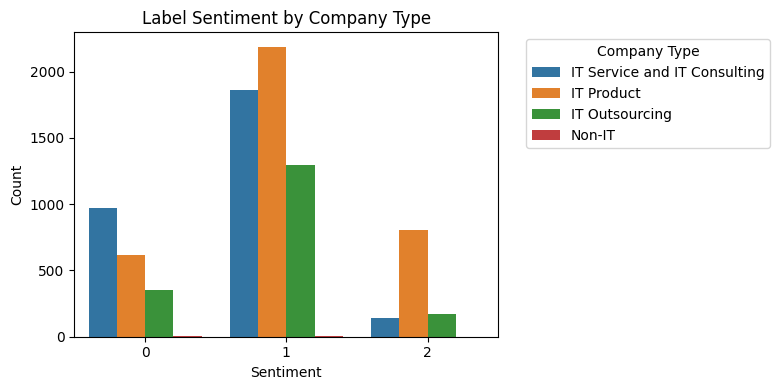

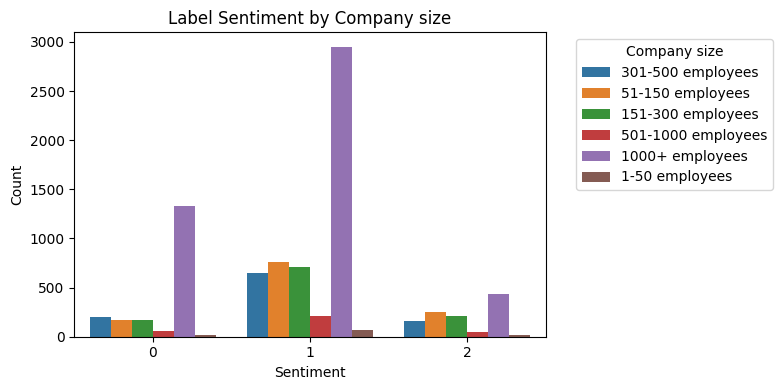

In [92]:
# Chuẩn hóa cột Cmt_daydatetime
Reviews['Cmt_day'] = pd.to_datetime(Reviews['Cmt_day'], format="%B %Y", errors='coerce')

#  Tạo cột mới  year
Reviews['Review_Year'] = Reviews['Cmt_day'].dt.year

#  Danh sách các nhóm cần phân tích
group_columns = ['Company Type', 'Company size']

# Vẽ biểu đồ đếm cho từng nhóm
for group in group_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=Reviews, x='label_sentiment', hue=group)
    plt.title(f'Label Sentiment by {group}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.legend(title=group, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


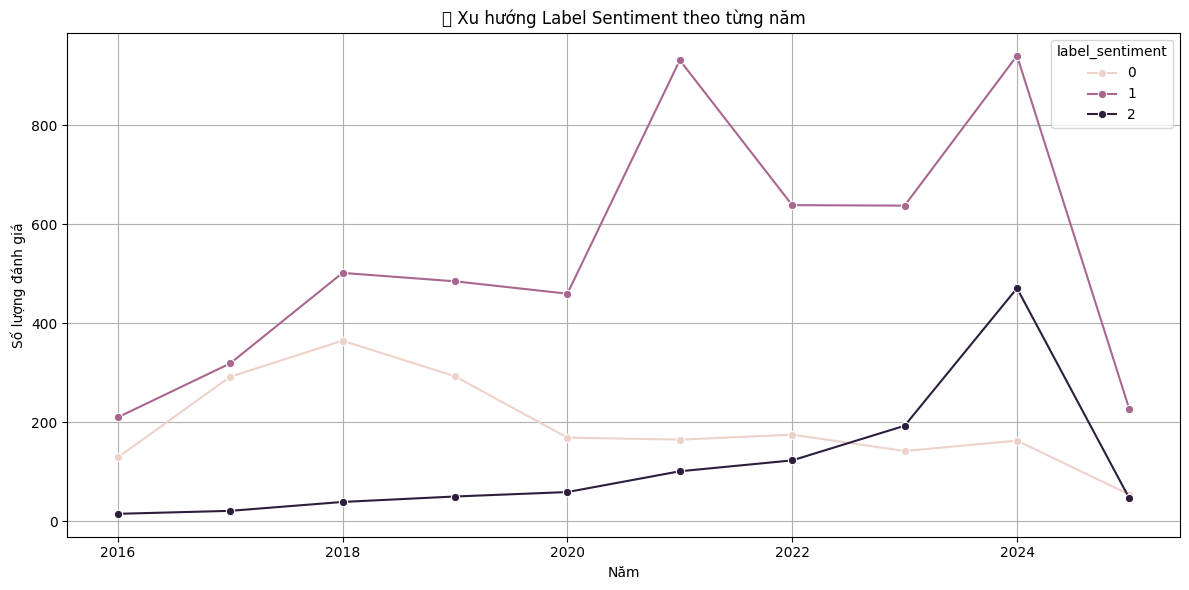

In [93]:
# Year
Reviews['Cmt_day'] = pd.to_datetime(Reviews['Cmt_day'], format='%B %Y', errors='coerce')
Reviews['Review_Year'] = Reviews['Cmt_day'].dt.year

# Đếm số lượng sentiment theo từng năm
sentiment_by_year = Reviews.groupby(['Review_Year', 'label_sentiment']).size().reset_index(name='count')

# Vẽ biểu đồ line
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_by_year, x='Review_Year', y='count', hue='label_sentiment', marker='o')
plt.title('📈 Xu hướng Label Sentiment theo từng năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng đánh giá')
plt.grid(True)
plt.tight_layout()
plt.show()


In [94]:
import plotly.express as px
import plotly.graph_objects as go

# Tính điểm trung bình theo quốc gia
country_sentiment = Reviews.groupby("Country")["label_sentiment"].mean().reset_index()

# Tạo bản đồ choropleth
fig = px.choropleth(
    country_sentiment,
    locations="Country",
    locationmode="country names",
    color="label_sentiment",
    color_continuous_scale="RdYlGn",  # Đỏ -> Vàng -> Xanh
    range_color=(0, 2),
    title="Average Sentiment by Country",
)

# Tắt viền bản đồ
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='natural earth'
    ),
    margin=dict(l=0, r=0, t=50, b=0),
)

# Lấy thông tin tọa độ
import pycountry
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="geoapi")

country_sentiment["lat"] = None
country_sentiment["lon"] = None

for idx, row in country_sentiment.iterrows():
    try:
        location = geolocator.geocode(row["Country"], timeout=10)
        if location:
            country_sentiment.at[idx, "lat"] = location.latitude
            country_sentiment.at[idx, "lon"] = location.longitude
        time.sleep(1)  # tránh bị chặn do quá nhiều request
    except:
        pass

# Thêm tên quốc gia
fig.add_trace(go.Scattergeo(
    locationmode='country names',
    lon=country_sentiment["lon"],
    lat=country_sentiment["lat"],
    text=country_sentiment["Country"],
    mode='text',
    showlegend=False,
    textfont=dict(color='black', size=9)
))

fig.show()


In [95]:
# Tính điểm trung bình label_sentiment theo quốc gia
country_sentiment = Reviews.groupby("Country")["label_sentiment"].mean().reset_index()

# Sắp xếp giảm dần
top_countries = country_sentiment.sort_values(by="label_sentiment", ascending=False)

# Lấy top 10
top_10 = top_countries.head(10)

print("Top 10 Countries by Sentiment:")
display(top_10)

Top 10 Countries by Sentiment:


,Country,label_sentiment
15,Sweden,1.528571
5,Estonia,1.500000
4,Denmark,1.412844
14,South Korea,1.362473
0,Australia,1.241206
13,Singapore,1.135309
12,Norway,1.126866
3,Canada,1.066667
1,Belgium,1.013333
2,Cambodia,1.000000


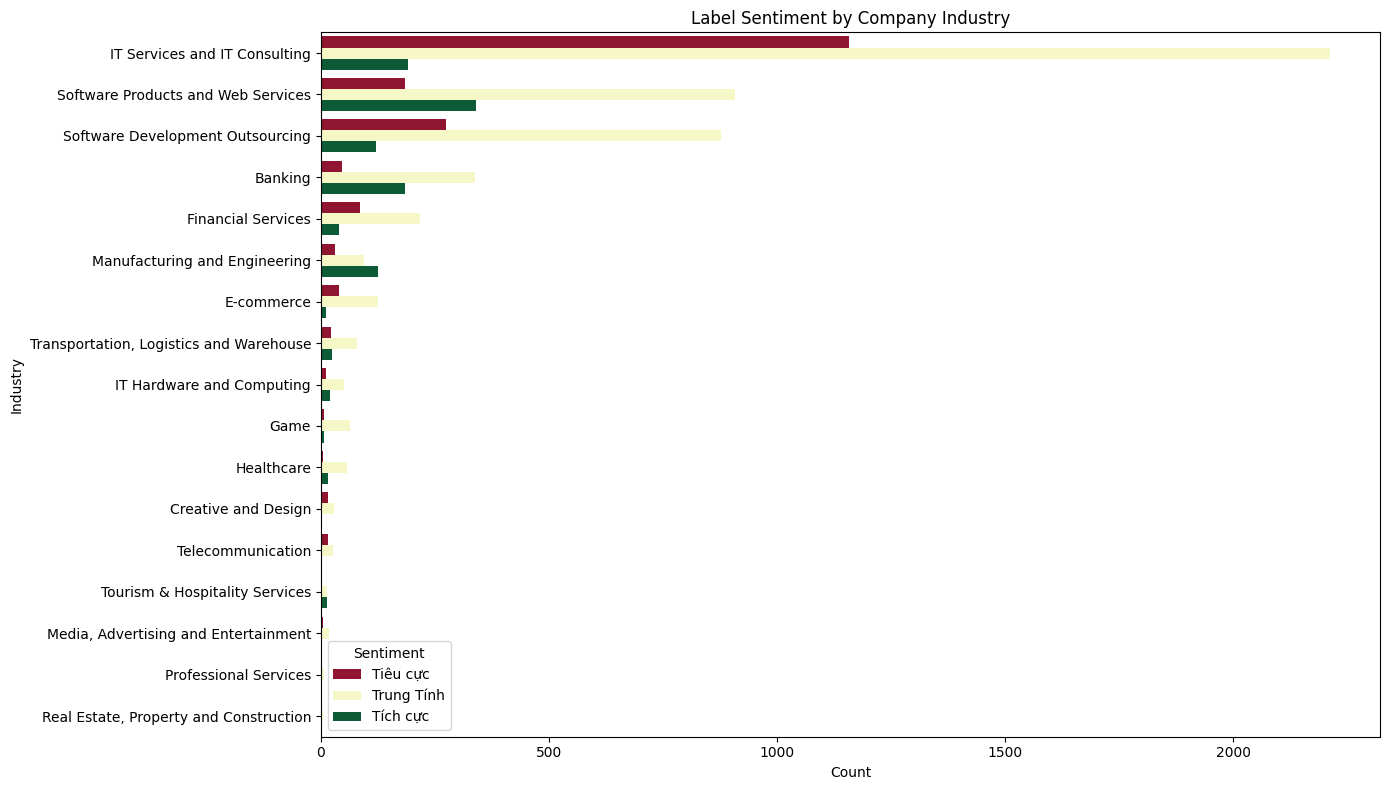

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))

# Sắp xếp
industry_order = Reviews['Company industry'].value_counts().index

sns.countplot(
    data=Reviews,
    y='Company industry',
    hue='label_sentiment',
    order=industry_order,
    palette='RdYlGn'
)

plt.title('Label Sentiment by Company Industry')
plt.xlabel('Count')
plt.ylabel('Industry')
plt.legend(title='Sentiment', labels=['Tiêu cực', 'Trung Tính', 'Tích cực'])
plt.tight_layout()
plt.show()


In [97]:
print(Reviews.columns)


Index(['id', 'Company Name', 'Cmt_day', 'Title', 'What I liked',
       'Suggestions for improvement', 'Rating', 'Salary & benefits',
       'Training & learning', 'Management cares about me', 'Culture & fun',
       'Office & workspace', 'Recommend?', 'Company Type', 'Company industry',
       'Company size', 'Country', 'Working days', 'Overtime Policy',
       'review_text', 'processed_text', 'pos_count', 'neg_count',
       'label_sentiment', 'Review_Year', 'combined_text', 'review_len',
       'text_processed'],
      dtype='object')


## MODEL

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import pandas as pd

In [105]:
# Văn bản & dữ liệu số
text_col = 'text_processed'
numeric_cols = [
    'Salary & benefits', 'Training & learning', 'Management cares about me',
    'Culture & fun', 'Office & workspace',
    'pos_count', 'neg_count', 'Review_Year'
]

# Tạo đặc trưng đầu vào và nhãn
X = Reviews[[text_col] + numeric_cols]
y = Reviews['label_sentiment']

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tạo preprocessor kết hợp TF-IDF và chuẩn hóa
preprocessor = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(norm='l2', max_features=768), text_col),
    ('num', StandardScaler(), numeric_cols)
])

In [106]:
# Mô hình cần đánh giá
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Huấn luyện và đánh giá
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Lưu mô hình pipeline đầy đủ
    joblib.dump(pipe, f'{name}_pipeline.pkl')
    print(f"Saved model to {name}_pipeline.pkl")


Training Logistic Regression...
Model: Logistic Regression
              precision    recall  f1-score   support

           0      0.843     0.787     0.814       389
           1      0.924     0.947     0.935      1071
           2      1.000     1.000     1.000       224

    accuracy                          0.917      1684
   macro avg      0.922     0.911     0.916      1684
weighted avg      0.916     0.917     0.916      1684

Confusion Matrix:
 [[ 306   83    0]
 [  57 1014    0]
 [   0    0  224]]
Saved model to Logistic Regression_pipeline.pkl

Training SVM...
Model: SVM
              precision    recall  f1-score   support

           0      0.804     0.748     0.775       389
           1      0.890     0.934     0.911      1071
           2      1.000     0.884     0.938       224

    accuracy                          0.884      1684
   macro avg      0.898     0.855     0.875      1684
weighted avg      0.885     0.884     0.883      1684

Confusion Matrix:
 [[ 291   

In [111]:
from tensorflow.keras.layers import Bidirectional

texts = Reviews['text_processed'].tolist()
labels = Reviews['label_sentiment'].values

max_words = 2000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_pad = pad_sequences(sequences, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X_pad, labels, test_size=0.2, random_state=42, stratify=labels)

model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.6084 - loss: 0.9349 - val_accuracy: 0.6443 - val_loss: 0.8092
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.6484 - loss: 0.7877 - val_accuracy: 0.6485 - val_loss: 0.7800
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.6682 - loss: 0.7254 - val_accuracy: 0.6562 - val_loss: 0.7787
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.6894 - loss: 0.6843 - val_accuracy: 0.6461 - val_loss: 0.7924
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.7213 - loss: 0.6501 - val_accuracy: 0.6283 - val_loss: 0.8101
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.7278 - loss: 0.6260 - val_accuracy: 0.6360 - val_loss: 0.8397
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.7395 - loss: 0.5900 - val_accuracy: 0.6223 - val_loss: 0.8579
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.7659 - loss: 0

In [112]:
# Lưu mô hình sau khi huấn luyện xong
model.save('sentiment_analysis_model_lstm.h5')
print("Model saved as 'sentiment_analysis_model_lstm.h5'")

Model saved as 'sentiment_analysis_model_lstm.h5'


In [113]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Chuyển đổi đầu ra softmax thành class labels

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [114]:
classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'])

'              precision    recall  f1-score   support\n\n    Negative       0.43      0.43      0.43       389\n     Neutral       0.68      0.74      0.71      1071\n    Positive       0.35      0.21      0.26       224\n\n    accuracy                           0.60      1684\n   macro avg       0.49      0.46      0.47      1684\nweighted avg       0.58      0.60      0.59      1684\n'

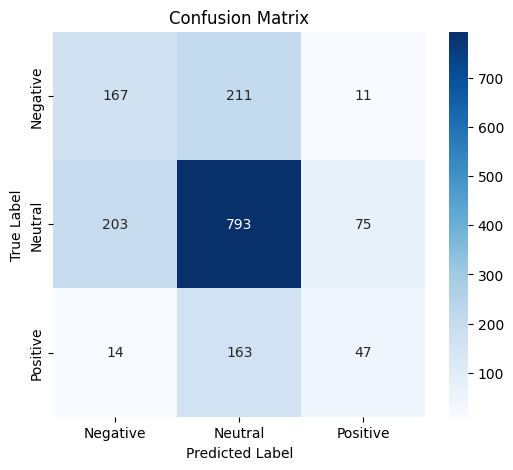

In [115]:
# In ra confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

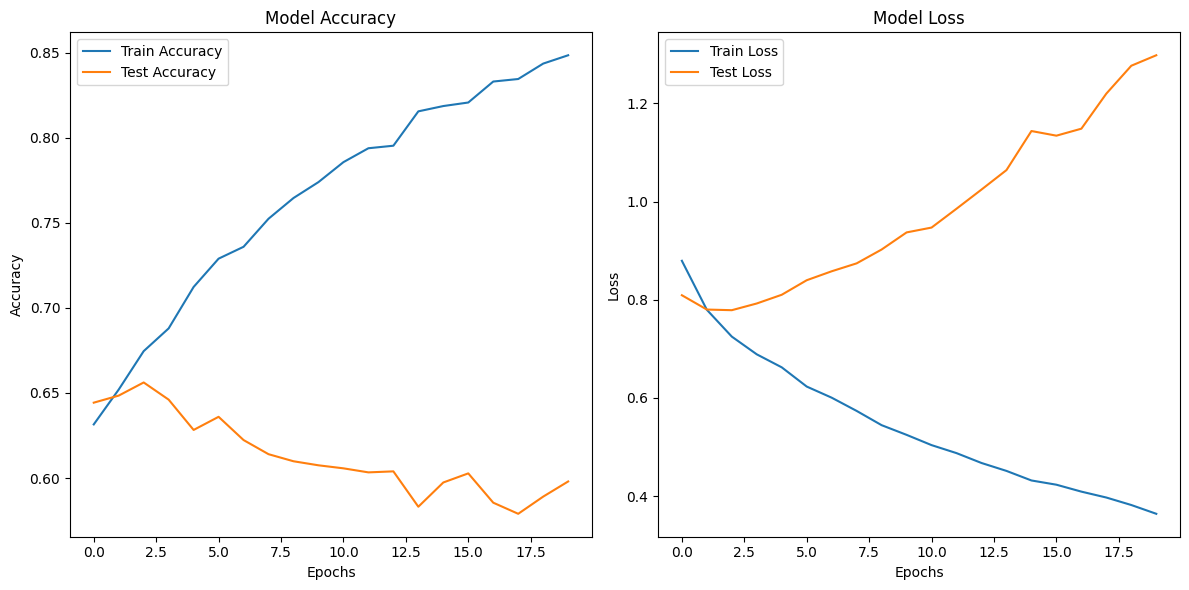

In [116]:
#  Plot Accuracy & Loss curves
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [117]:
# Tính ROC curve cho từng lớp
fpr = {}
tpr = {}
roc_auc = {}

In [118]:
n_classes = 3  # Số lớp cảm xúc: Negative, Neutral, Positive
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, model.predict(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


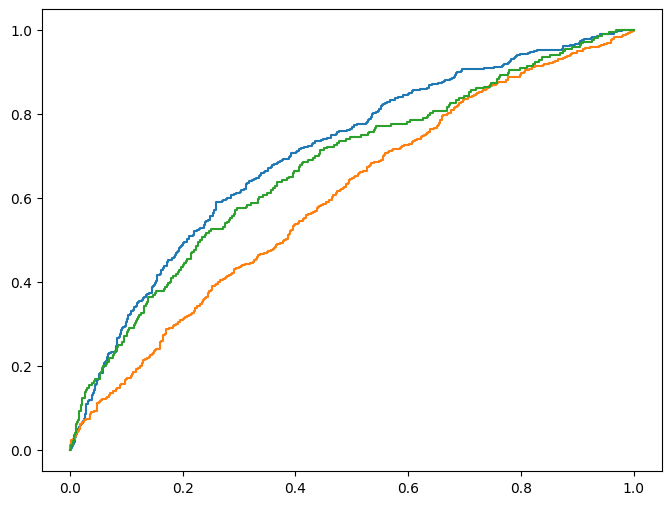

In [119]:
# Vẽ ROC curve cho từng lớp
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')


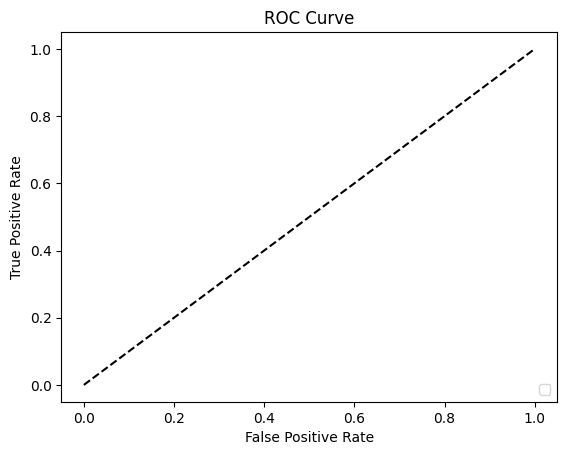

In [120]:
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Mô hình Random Forest với PhoBERT embeddings


In [122]:
phobert = 'vinai/phobert-base'
tokenizer = AutoTokenizer.from_pretrained(phobert)
model = AutoModel.from_pretrained(phobert)

In [123]:
def get_phobert_embedding(texts):
    features = []
    with torch.no_grad():
        for text in tqdm(texts):
            input_ids = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=128)
            outputs = model(input_ids)
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
            features.append(embedding)
    return np.array(features)


In [127]:
# Tiền xử lý và lấy embedding PhoBERT
X_phobert = get_phobert_embedding(Reviews['text_processed'].tolist())
y = Reviews['label_sentiment'].values


100%|██████████████████████████████████████████████████████████████████████████████| 8417/8417 [05:55<00:00, 23.65it/s]


In [128]:
# Chia dữ liệu train và test
X_train, X_test, y_train, y_test = train_test_split(X_phobert, y, test_size=0.2, random_state=42, stratify=y)


In [129]:
# Huấn luyện mô hình Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [130]:
# Lưu mô hình Random Forest sau khi huấn luyện
import joblib
joblib.dump(clf, 'random_forest_model.pkl')
print("Model saved as 'random_forest_model.pkl'")

Model saved as 'random_forest_model.pkl'


In [131]:
classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'])

'              precision    recall  f1-score   support\n\n    Negative       0.56      0.09      0.16       389\n     Neutral       0.64      0.97      0.78      1071\n    Positive       0.50      0.00      0.01       224\n\n    accuracy                           0.64      1684\n   macro avg       0.57      0.36      0.31      1684\nweighted avg       0.61      0.64      0.53      1684\n'

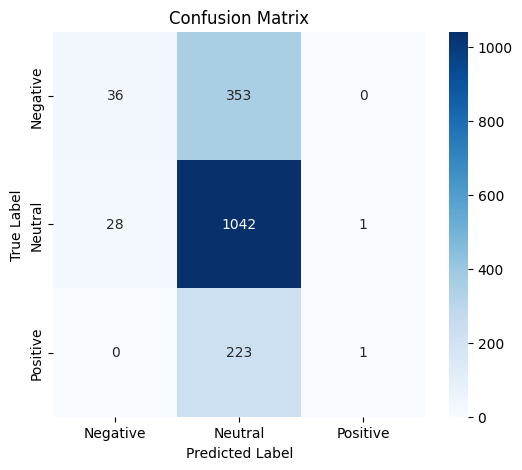

In [132]:
# In ra confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

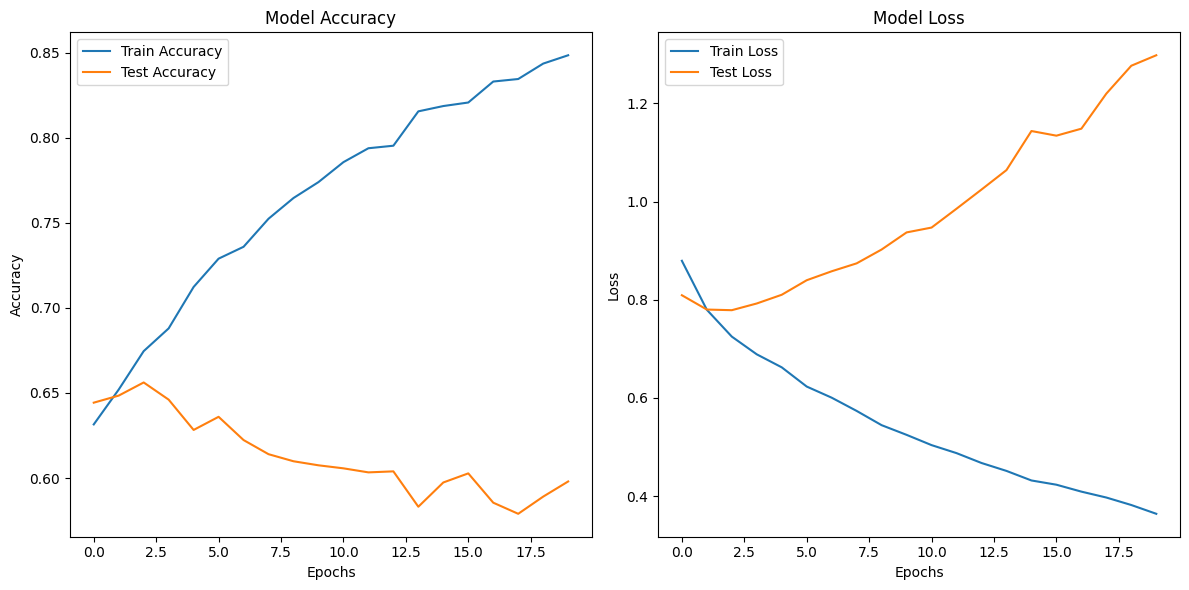

In [133]:
## 4. ROC Curve (cho từng lớp)
fpr = {}
tpr = {}
roc_auc = {}
# Plot Accuracy & Loss curves
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [134]:
# ROC Curve (cho từng lớp)
fpr = {}
tpr = {}
roc_auc = {}


In [135]:
n_classes = 3  # Số lớp cảm xúc: Negative, Neutral, Positive
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, clf.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

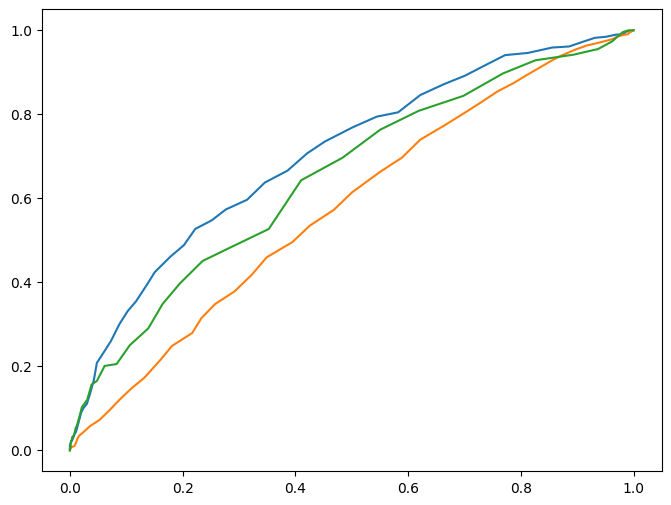

In [136]:
# Vẽ ROC curve cho từng lớp
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')


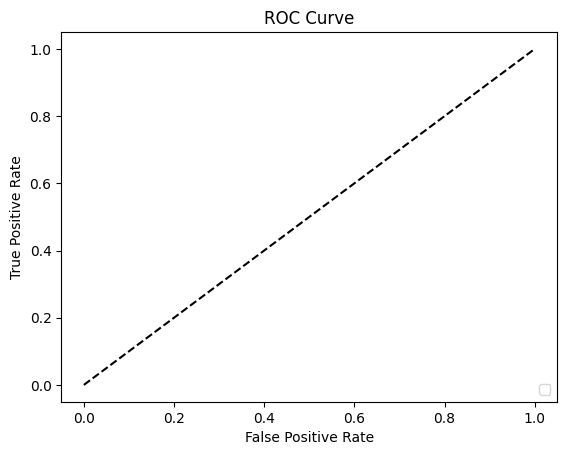

In [137]:
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# PHÂN CỤM THÔNG TIN REVIEW

In [138]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

In [140]:
vectorizer = CountVectorizer(max_features=2000)
X_count = vectorizer.fit_transform(Reviews['text_processed'])

In [141]:
K = range(2, 10)
inertia = []
silhouette = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans.fit_predict(X_count)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_count, labels_k))

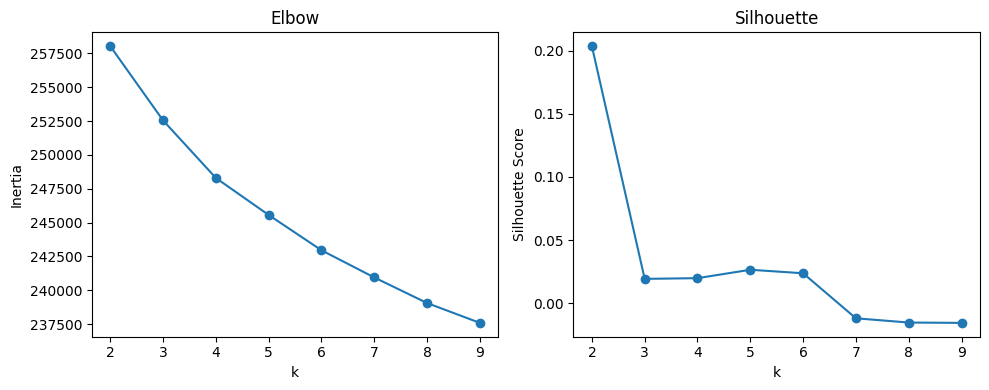

In [142]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.title('Elbow')
plt.xlabel('k'); plt.ylabel('Inertia')
plt.subplot(1,2,2)
plt.plot(K, silhouette, marker='o')
plt.title('Silhouette')
plt.xlabel('k'); plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


In [144]:
# Chọn số cụm
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_count)
Reviews['cluster'] = labels

In [146]:
# Giảm chiều để scatter
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_count.toarray())
Reviews['x_pca'] = X_pca[:, 0]
Reviews['y_pca'] = X_pca[:, 1]

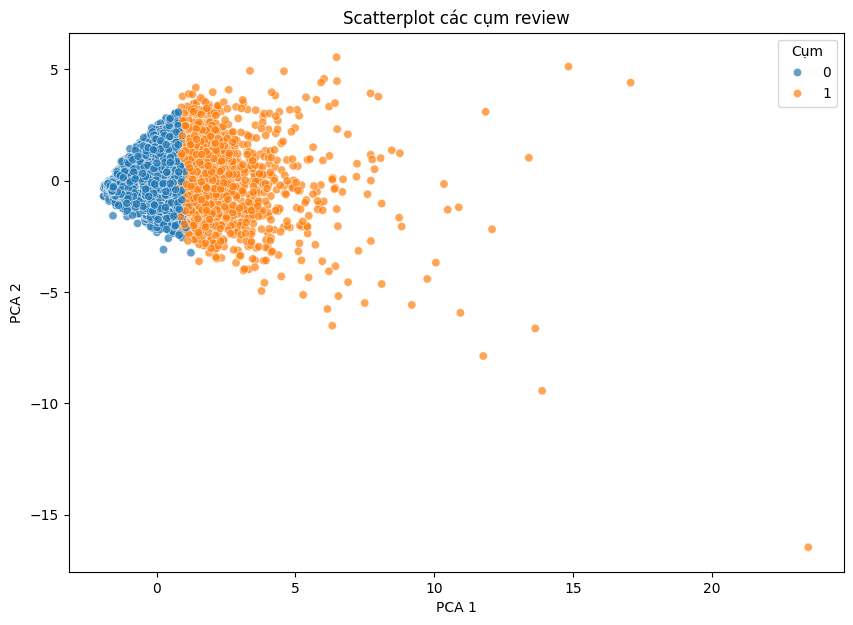

In [148]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=Reviews, x='x_pca', y='y_pca', hue='cluster', palette='tab10', alpha=0.7)
plt.title('Scatterplot các cụm review')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cụm')
plt.show()

In [149]:
# Tính toán Silhouette Score cho KMeans
sil_score_kmeans = silhouette_score(X_count, labels, metric='euclidean')

# In ra kết quả Silhouette Score cho KMeans
print(f"Silhouette Score (KMeans): {sil_score_kmeans}")

Silhouette Score (KMeans): 0.20373745547222719


In [151]:
import hdbscan

vectorizer = CountVectorizer(max_features=2000)
X_count = vectorizer.fit_transform(Reviews['text_processed'])


In [153]:
# HDBSCAN model
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean')
labels_hdbscan = hdbscan_model.fit_predict(X_count)

# Add cluster labels to dataframe
Reviews['cluster_hdbscan'] = labels_hdbscan


In [154]:
# Reducing dimensions to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_count.toarray())
Reviews['x_pca'] = X_pca[:, 0]
Reviews['y_pca'] = X_pca[:, 1]


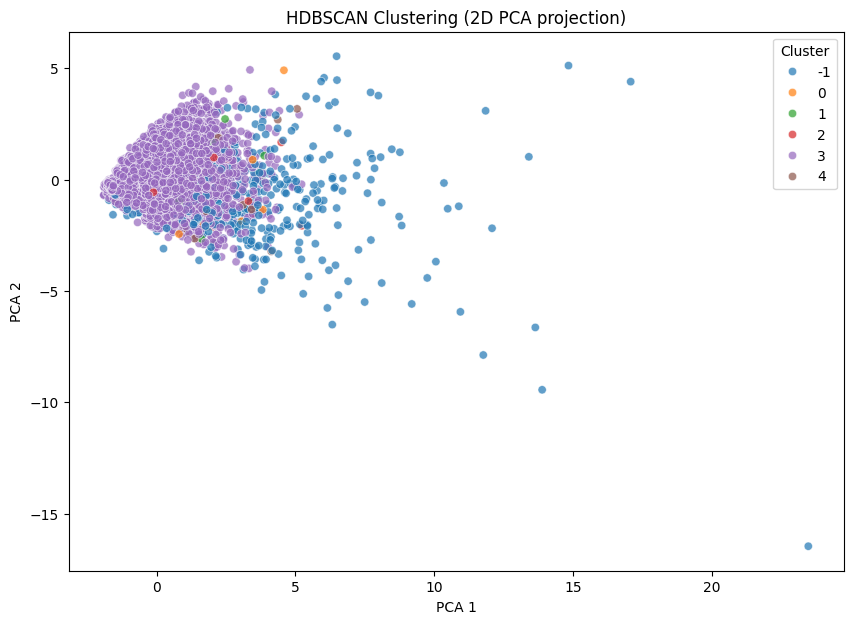

In [155]:
# 🎯 Improved HDBSCAN Clustering Visualization (PCA 2D)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=Reviews,
    x='x_pca',
    y='y_pca',
    hue='cluster_hdbscan',
    palette='Set2',
    edgecolor='black',
    s=60,
    alpha=0.8
)
plt.title('Biểu đồ phân cụm HDBSCAN (PCA 2D)', fontsize=14)
plt.xlabel('Thành phần PCA 1')
plt.ylabel('Thành phần PCA 2')
plt.legend(title='Cụm', loc='best')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [156]:
# Lưu mô hình HDBSCAN
joblib.dump(hdbscan_model, 'hdbscan_model.pkl')

# In ra thông báo lưu thành công
print("Mô hình HDBSCAN đã được lưu thành công.")

Mô hình HDBSCAN đã được lưu thành công.


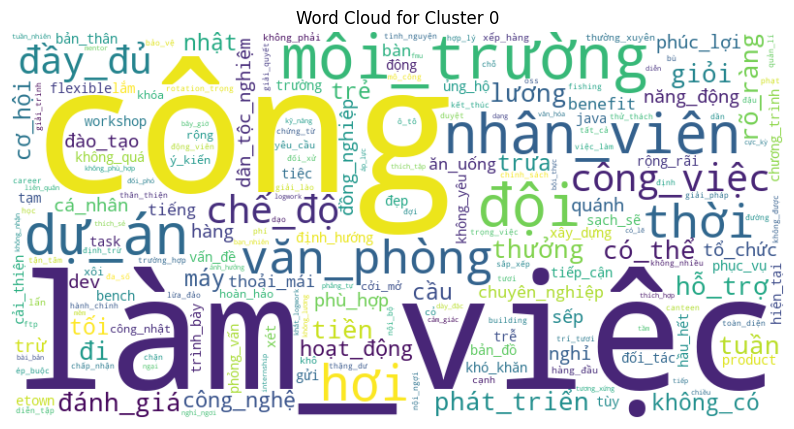

In [159]:
from wordcloud import WordCloud

# Tạo WordCloud cho cụm đầu tiên (cluster 0)
cluster_0_reviews = Reviews[Reviews['cluster_hdbscan'] == 0]['text_processed']

# Tạo WordCloud cho cụm đầu tiên
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_0_reviews))

# Hiển thị WordCloud
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Cluster 0')
plt.axis('off')
plt.show()

### XUẤT TỪ KHÓA ĐẶC TRƯNG, WORDCLOUD, THỐNG KÊ

In [160]:
# Với KMeans
terms = vectorizer.get_feature_names_out()
num_keywords = 10
for i in range(k):
    print(f"\nTop {num_keywords} từ khóa cụm {i}:")
    top_indices = kmeans.cluster_centers_[i].argsort()[::-1][:num_keywords]
    print(', '.join(terms[j] for j in top_indices))



Top 10 từ khóa cụm 0:
môi_trường, lương, làm_việc, công, nhân_viên, văn_phòng, dự_án, công_việc, sếp, thân_thiện

Top 10 từ khóa cụm 1:
công, làm_việc, nhân_viên, môi_trường, lương, đi, công_việc, đội, phát_triển, đồng_nghiệp


In [162]:
# Lấy danh sách các từ trong từ điển
terms = vectorizer.get_feature_names_out()
num_keywords = 10
# Duyệt qua từng cụm và in ra các từ khóa quan trọng
for i in np.unique(labels_hdbscan):
    if i != -1:  # Loại bỏ các điểm nhiễu có nhãn -1
        print(f"\nTop {num_keywords} từ khóa trong cụm {i}:")
        cluster_reviews = Reviews[Reviews['cluster_hdbscan'] == i]['text_processed']
        cluster_matrix = vectorizer.transform(cluster_reviews)
        
        # Tính tổng tần suất các từ trong cụm này
        word_counts = np.asarray(cluster_matrix.sum(axis=0)).flatten()
        
        # Lấy các từ có tần suất cao nhất
        top_indices = word_counts.argsort()[::-1][:num_keywords]
        
        # In ra các từ khóa
        print(', '.join(terms[j] for j in top_indices))


Top 10 từ khóa trong cụm 0:
công, làm_việc, môi_trường, đội, dự_án, nhân_viên, hơi, thời, văn_phòng, đầy_đủ

Top 10 từ khóa trong cụm 1:
làm_việc, công, công_việc, nhân_viên, môi_trường, đi, lương, phát_triển, dự_án, đánh_giá

Top 10 từ khóa trong cụm 2:
công, nhân_viên, làm_việc, lương, môi_trường, có_thể, đội, đi, chế_độ, đồng_nghiệp

Top 10 từ khóa trong cụm 3:
làm_việc, môi_trường, lương, công, nhân_viên, văn_phòng, dự_án, công_việc, thân_thiện, đồng_nghiệp

Top 10 từ khóa trong cụm 4:
công, làm_việc, đi, đội, lương, nhân_viên, công_việc, môi_trường, không_có, hơi


### PHÂN TÍCH SÂU THEO CÔNG TY

In [165]:
# Lặp qua từng công ty trong cột 'Company Name'
for company in Reviews['Company Name'].unique():
    print(f'\n--- {company} ---')
    
    # Thống kê số lượng các giá trị trong cột 'cluster_hdbscan' cho mỗi công ty
    print(Reviews[Reviews['Company Name'] == company]['cluster_hdbscan'].value_counts())



--- Accenture ---
cluster_hdbscan
3    18
Name: count, dtype: int64

--- Adnovum Vietnam ---
cluster_hdbscan
 3    4
-1    2
Name: count, dtype: int64

--- Ahamove ---
cluster_hdbscan
 3    11
-1     1
Name: count, dtype: int64

--- Allexceed Việt Nam ---
cluster_hdbscan
 3    16
-1     1
Name: count, dtype: int64

--- Alpaca Vietnam ---
cluster_hdbscan
3    5
Name: count, dtype: int64

--- ANDPAD VietNam Co., Ltd ---
cluster_hdbscan
3    10
Name: count, dtype: int64

--- ARIS Vietnam ---
cluster_hdbscan
3    13
Name: count, dtype: int64

--- Asilla ---
cluster_hdbscan
3    10
Name: count, dtype: int64

--- Athena Studio ---
cluster_hdbscan
3    25
Name: count, dtype: int64

--- Aviron ---
cluster_hdbscan
3    4
Name: count, dtype: int64

--- AZoom VietNam ---
cluster_hdbscan
3    5
Name: count, dtype: int64

--- AZPLAYS Co., LTD ---
cluster_hdbscan
3    6
Name: count, dtype: int64

--- BAN VIEN CORPORATION ---
cluster_hdbscan
3    42
Name: count, dtype: int64

--- bbv Vietnam ---
clu

### LƯU BẢNG SUMMARY TOPIC + TỪ KHÓA

In [167]:
# Lặp qua các cụm trong HDBSCAN
cluster_summary = []

for cluster in set(labels_hdbscan):  # labels_hdbscan là nhãn phân cụm từ HDBSCAN
    if cluster == -1:  # Loại bỏ điểm nhiễu (-1 là điểm nhiễu trong HDBSCAN)
        continue
    
    # Tìm các từ khóa cho cụm này (dùng CountVectorizer để lấy từ khóa)
    cluster_reviews = Reviews[Reviews['cluster_hdbscan'] == cluster]['text_processed']
    cluster_matrix = vectorizer.transform(cluster_reviews)
    
    # Tính tổng tần suất từ trong cụm này
    word_counts = np.asarray(cluster_matrix.sum(axis=0)).flatten()
    
    # Lấy các từ có tần suất cao nhất
    top_indices = word_counts.argsort()[::-1][:10]  # Top 10 từ khóa
    kw_list = [str(vectorizer.get_feature_names_out()[i]) for i in top_indices]  # Chuyển thành chuỗi
    
    # Đếm số lượng đánh giá trong cụm này
    count = len(cluster_reviews)
    
    # Thêm thông tin cụm vào danh sách tổng hợp
    cluster_summary.append({
        'cluster': cluster, 
        'num_reviews': count, 
        'keywords': ', '.join(kw_list)  # Join lại các từ khóa thành chuỗi
    })

# Lưu kết quả vào Excel
cluster_summary_df = pd.DataFrame(cluster_summary)
cluster_summary_df.to_excel('hdbscan_cluster_summary.xlsx', index=False)
